In [1]:
import os
import sys
module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)
    
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from src.config import get_dataset_and_user
from src.user import DummyUser
%matplotlib inline

In [2]:
# get data
X_iris, user_iris = get_dataset_and_user('iris')
y_iris = user_iris.get_label(X_iris, update_counter=False)

X_housing, user_housing = get_dataset_and_user('housing')
y_housing = user_housing.get_label(X_housing, update_counter=False)

X_sdss, user_sdss = get_dataset_and_user('sdss_Q2.1')

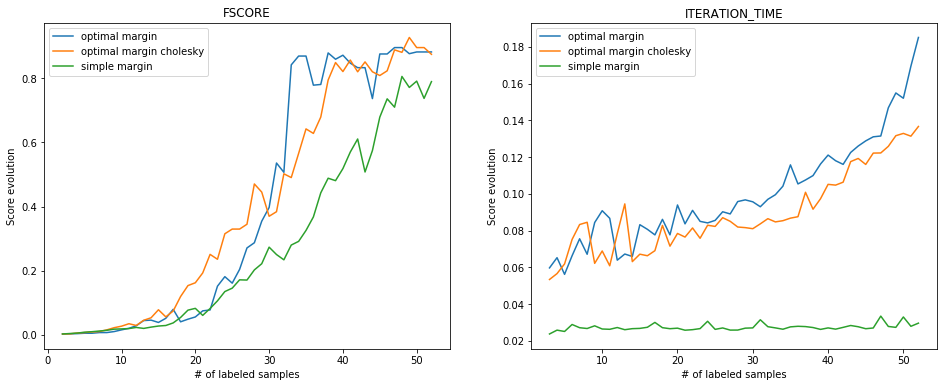

In [13]:
from src.active_learning.svm import SimpleMargin, SolverMethod, OptimalMargin
from src.active_learning.svm.base import OptimalMarginCholesky
from src.active_learning.linear import LinearMajorityVote, KernelMajorityVote
from src.active_learning.agnostic import RandomLearner
from src.showdown import Showdown
from src.plotting import plot_showdown
from src.initial_sampling import StratifiedSampler
from sklearn.svm import SVC

user_housing.max_iter = 35
user_iris.max_iter = 10
user_sdss.max_iter = 50

active_learners_list = [
    #("random", RandomLearner(SVC(C=100000, kernel='rbf'))),
    ("optimal margin", OptimalMargin(chain_length=25, sample_size=16, kind='kernel', kernel='rbf', C=100000)),
    ("optimal margin cholesky", OptimalMarginCholesky(chain_length=25, sample_size=16, kind='kernel', kernel='rbf', C=100000)),
    ("simple margin", SimpleMargin(kind='kernel', kernel='rbf', C=100000)),
]

datasets_list = [
    ('sdss', X_sdss, user_sdss)
    #("housing", X_housing, user_housing),
    #("iris", X_iris, user_iris)
]
times = 1
showdown = Showdown()
output = showdown.run(datasets_list, active_learners_list, times, StratifiedSampler(1,1))

#print(output.head())
plot_showdown(output, times, metrics_list=['fscore', 'iteration_time'])

In [6]:
output['housing']['fscore']

optimal margin                               optimal margin cholesky  \
              max      mean       min       std                     max   
2        0.530612  0.335575  0.045296  0.222995                0.530612   
3        0.666667  0.416172  0.074906  0.283560                0.611111   
4        0.625000  0.441170  0.255319  0.135770                0.846154   
5        0.800000  0.574322  0.369231  0.185369                0.896552   
6        0.833333  0.749555  0.571429  0.111693                0.833333   
7        0.880000  0.744571  0.476190  0.159253                0.880000   
8        0.880000  0.809333  0.733333  0.053666                0.880000   
9        0.880000  0.793179  0.733333  0.061583                0.923077   
10       0.880000  0.799665  0.750000  0.048492                0.916667   
11       0.833333  0.796998  0.750000  0.035999                0.916667   
12       0.869565  0.814389  0.750000  0.046718                0.916667   
13       0.880000  0.825182  0.709677  0.067914                0.916667   
14       0.880000  0.848764  0.827586  0.024151                0.916667   
15       0.880000  0.854675  0.833333  0.021096                0.916667   
16       0.960000  0.891913  0.833333  0.048274                0.960000   
17       0.960000  0.891913  0.833333  0.048274                0.960000   
18       0.960000  0.882493  0.833333  0.046809                0.960000   
19       0.960000  0.882493  0.833333  0.046809                0.960000   
20       0.960000  0.882493  0.833333  0.046809                0.960000   
21       0.960000  0.851947  0.727273  0.083944                0.960000   
22       0.960000  0.845623  0.695652  0.096009                0.960000   
23       0.960000  0.845623  0.695652  0.096009                0.960000   
24       0.960000  0.845623  0.695652  0.096009                0.960000   
25       0.960000  0.889826  0.833333  0.049136                0.960000   
26       0.960000  0.889723  0.785714  0.066361                0.960000   
27       0.960000  0.889723  0.785714  0.066361                0.960000   
28       0.916667  0.881056  0.785714  0.057067                0.960000   
29       0.916667  0.881056  0.785714  0.057067                0.960000   
30       0.916667  0.881056  0.785714  0.057067                1.000000   
31       0.916667  0.899913  0.869565  0.023236                1.000000   
32       0.960000  0.908580  0.869565  0.035755                1.000000   
33       0.960000  0.908580  0.869565  0.035755                1.000000   
34       0.960000  0.917246  0.869565  0.042769                1.000000   
35       0.960000  0.925913  0.869565  0.046821                1.000000   
36       1.000000  0.933913  0.869565  0.056515                1.000000   
37       1.000000  0.949913  0.869565  0.048140                1.000000   

                                 simple margin                                
        mean       min       std           max      mean       min       std  
2   0.335575  0.045296  0.222995      0.530612  0.335575  0.045296  0.222995  
3   0.349996  0.076628  0.239418      0.666667  0.412269  0.071174  0.275933  
4   0.650145  0.425532  0.168260      0.833333  0.554131  0.140845  0.256341  
5   0.810695  0.620690  0.109504      0.833333  0.677157  0.294118  0.230929  
6   0.731233  0.356164  0.210166      0.800000  0.684199  0.555556  0.120466  
7   0.725524  0.247619  0.267920      0.916667  0.838788  0.727273  0.080778  
8   0.731677  0.195489  0.300352      0.916667  0.836807  0.787879  0.050561  
9   0.895640  0.869565  0.023265      0.923077  0.860858  0.787879  0.051690  
10  0.874155  0.787879  0.052710      0.880000  0.861333  0.800000  0.034769  
11  0.909333  0.880000  0.016398      0.916667  0.884184  0.827586  0.036567  
12  0.828208  0.558140  0.152463      0.923077  0.897906  0.857143  0.031953  
13  0.688712  0.530612  0.192125      0.962963  0.933839  0.869565  0.040752  
14  0.688712  0.530612  0.192125      0.962963

In [5]:
from datetime import datetime

def point_parser(s):
    s = s[1:-1]  # remove square brackets
    arrays = s.split('\n')
    arrays_without_brackets = map(lambda x: x.strip()[1:-1], arrays)
    final = list(map(lambda x: [float(y) for y in x.split()], arrays_without_brackets))
    return final[0]

def parse_log(path='task.log'):
    with open(path, 'r') as f:
        for line in f:
            timestamp, _, _, _, iteration, point, label = line.strip().split('\t')
            timestamp = datetime.strptime(timestamp, "%Y-%m-%d %H:%M:%S,%f").timestamp()
            point = point_parser(point)
            label = float(label)
            iteration = int(iteration)
            yield timestamp, iteration, point, label

logs = parse_log()            
t0, i0, x0, l0 = next(logs)
points = []
labels = []
for t, i, x, l in logs:
    points.append(x)
    labels.append(l)
    if i != i0:
        i0 = i
        # compute metrics
        pass

print(points)
print(labels)

ValueError: not enough values to unpack (expected 7, got 6)